In [68]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import scipy.stats as scs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import seaborn as sns
import lightgbm as lgb
import itertools
from pylab import rcParams

In [ ]:
rcParams['figure.figsize'] = 16, 5
pd.set_option('display.max_columns', 500)
plt.style.use('seaborn-whitegrid')

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [3]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
df.shape

(145374, 13)

In [4]:
#по неделям
df_w = df.resample('W').mean()
df_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,11.50000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,11.50000,0.000000,0.000000,0.000000


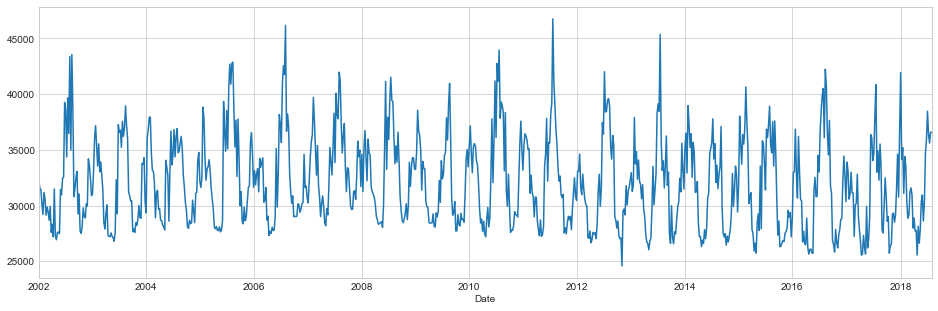

In [69]:
df_w['PJME_MW'].plot()

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

In [6]:
#удалим лишние для данной модели признаки:
df_w.drop(['hour', 'dayofweek', 'year'], axis=1, inplace=True)

Построим кластеризационный признак

In [7]:
scl=StandardScaler()
tsne_ =TSNE(n_components=2)

X = df_w.iloc[:,:-1].values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)

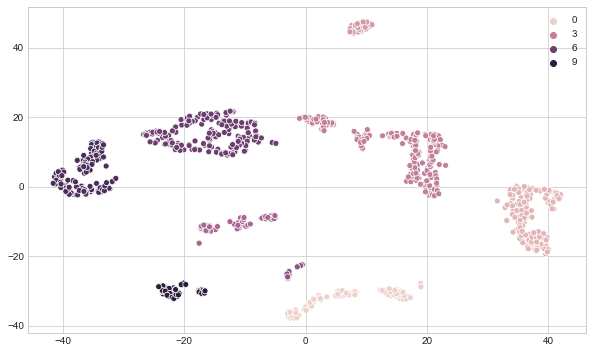

In [72]:
rcParams['figure.figsize'] = 10, 6
clast_0 = DBSCAN(eps=5, leaf_size=15 )
clast_1 = DBSCAN(eps=2, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

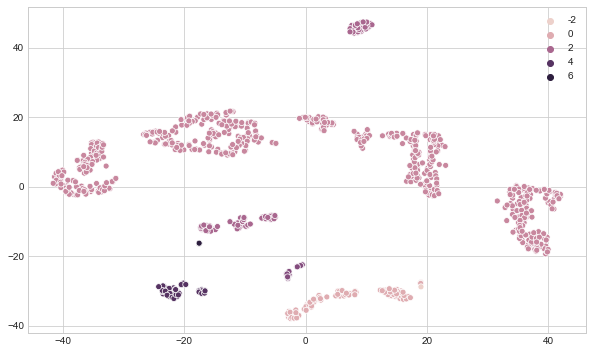

In [73]:
sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_scale_clast )
plt.show()

In [10]:
print('Число кластеров с масштабированием: ',len(np.unique(X_scale_clast)))
print('Число кластеров без масштабирования: ',len(np.unique(X_clast)))

Число кластеров с масштабированием:  7
Число кластеров без масштабирования:  9


На графике выглядит более логичной кластеризация без масштабирования, но закинем в признаки оба варианта и посмотрим на модели в дальнейшем

In [11]:
df_w['X_clast'] = X_clast
df_w['X_scale_clast'] = X_scale_clast
df_w['X_clast'].value_counts()

3    181
6    167
1    139
7    117
0     98
4     63
8     48
2     34
5     19
Name: X_clast, dtype: int64

In [12]:
df_w['X_scale_clast'].value_counts()

 1    604
 0     97
 2     92
 4     48
 3     19
 5      5
-1      1
Name: X_scale_clast, dtype: int64

In [13]:
df_w.loc[df_w['X_clast']==3].describe()

,PJME_MW,month,dayofmonth,quarter,dayofyear,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,X_clast,X_scale_clast
count,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.0,181.0,181.0,181.0,181.0
mean,29811.555410,4.926579,14.776137,1.995245,133.126774,19.480663,0.0,0.0,0.0,3.0,1.0
std,3419.686635,0.866722,6.572588,0.067276,27.657870,3.960347,0.0,0.0,0.0,0.0,0.0
min,25548.202381,3.568862,3.982036,1.568862,91.000000,13.000000,0.0,0.0,0.0,3.0,1.0
25%,27459.702381,4.000000,9.000000,2.000000,110.000000,16.000000,0.0,0.0,0.0,3.0,1.0
50%,28461.113095,5.000000,14.285714,2.000000,128.000000,19.000000,0.0,0.0,0.0,3.0,1.0
75%,31484.488095,6.000000,20.000000,2.000000,162.000000,24.000000,0.0,0.0,0.0,3.0,1.0
max,41187.464286,6.285714,27.000000,2.285714,180.000000,26.000000,0.0,0.0,0.0,3.0,1.0


In [14]:
df_w.loc[df_w['X_clast']==6].describe()

,PJME_MW,month,dayofmonth,quarter,dayofyear,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,X_clast,X_scale_clast
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.0,167.0,167.0,167.0,167.0
mean,35660.943687,7.915771,17.308864,2.994012,226.949256,32.874251,0.0,0.0,0.0,6.0,1.0
std,4308.880255,0.831438,6.183325,0.148224,26.876455,3.840463,0.0,0.0,0.0,0.0,0.0
min,26613.297619,6.000000,4.000000,2.000000,160.000000,23.000000,0.0,0.0,0.0,6.0,1.0
25%,32670.913690,7.000000,12.000000,3.000000,206.000000,30.000000,0.0,0.0,0.0,6.0,1.0
50%,35790.125000,8.000000,17.714286,3.000000,223.000000,32.000000,0.0,0.0,0.0,6.0,1.0
75%,38775.324405,9.000000,22.000000,3.000000,255.000000,37.000000,0.0,0.0,0.0,6.0,1.0
max,46761.494048,9.428571,28.000000,3.428571,274.000000,40.000000,0.0,0.0,0.0,6.0,1.0


Добавим признаки на основе компонетного анализа

In [15]:
pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])
Xpca.shape

(866, 2)

In [16]:
df_w['pca1']=Xpca[:,0]
df_w['pca2']=Xpca[:,1]

Добавим признаки, описывающие содержание ряда, и другие признаки

In [17]:
first_diff =np.array(df_w.iloc[1:,0].values - df_w.iloc[:-1,0].values).astype('float32') 
df_w['diff1'] = 0
df_w['diff1'] =  df_w['diff1'].astype('float') 
df_w['diff1'].values[1:] = first_diff

In [18]:
first_diff_d =(first_diff) / df_w.iloc[1:,0].values
df_w['diff1_d'] = 0
df_w['diff1_d'] =  df_w['diff1_d'].astype('float') 
df_w['diff1_d'].values[1:] = np.array(first_diff_d).astype('float32')

In [19]:
first_diff_l =np.log(df_w.iloc[1:,0].values)
df_w['diff1_l'] = 0
df_w['diff1_l'] =  df_w['diff1_l'].astype('float') 
df_w['diff1_l'].values[1:] = first_diff_l

Добавим скользящее среднее с глубиной 4 недели

In [20]:
df_w['d_w4'] = df_w['PJME_MW'].rolling(window=4).mean()

 и экспонентциальную среднюю

In [21]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [22]:
df_w['exp_0_05'] = exponential_smoothing(df_w['PJME_MW'], 0.05)

In [23]:
df_w.head(10)

,PJME_MW,month,dayofmonth,quarter,dayofyear,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,X_clast,X_scale_clast,pca1,pca2,diff1,diff1_d,diff1_l,d_w4,exp_0_05
Date,,,,,,,,,,,,,,,,,,
2002-01-06,32392.160839,1.000000,3.517483,1.0,3.517483,1.0,0.160839,0.000000,0.167832,0,0,-3.079148,1.526968,0.000000,0.000000,0.000000,NaN,32392.160839
2002-01-13,31487.386905,1.000000,10.000000,1.0,10.000000,2.0,0.000000,0.000000,0.000000,1,1,-3.199939,-0.377847,-904.773926,-0.028734,10.357342,NaN,32346.922142
2002-01-20,31452.880952,1.000000,17.000000,1.0,17.000000,3.0,0.000000,0.142857,0.000000,2,2,-2.844288,1.497717,-34.505951,-0.001097,10.356246,NaN,32302.220083
2002-01-27,30141.529762,1.000000,24.000000,1.0,24.000000,4.0,0.142857,0.000000,0.142857,0,0,-2.801122,1.644243,-1311.351196,-0.043506,10.313659,31368.489615,32194.185567
2002-02-03,29196.488095,1.428571,17.714286,1.0,31.000000,5.0,0.000000,0.000000,0.000000,1,1,-2.897072,-0.274735,-945.041687,-0.032368,10.281804,30569.571429,32044.300693
2002-02-10,31150.517857,2.000000,7.000000,1.0,38.000000,6.0,0.000000,0.000000,0.000000,1,1,-2.800806,-0.488560,1954.029785,0.062729,10.346586,30485.354167,31999.611551
2002-02-17,30616.565476,2.000000,14.000000,1.0,45.000000,7.0,0.000000,0.142857,0.000000,2,2,-2.445155,1.387005,-533.952393,-0.017440,10.329296,30276.275298,31930.459248
2002-02-24,29144.130952,2.000000,21.000000,1.0,52.000000,8.0,0.142857,0.000000,0.142857,0,0,-2.401989,1.533530,-1472.434570,-0.050523,10.280009,30026.925595,31791.142833
2002-03-03,29869.011905,2.428571,16.000000,1.0,59.000000,9.0,0.000000,0.000000,0.000000,1,1,-2.491379,-0.362330,724.880981,0.024269,10.304577,30195.056548,31695.036287


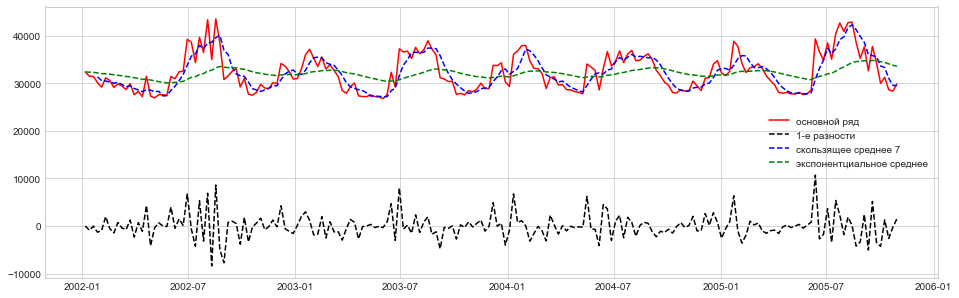

In [74]:
rcParams['figure.figsize'] = 16, 5
N100=200
plt.plot(df_w.index[:N100],df_w['PJME_MW'][:N100],'r',label ='основной ряд')
plt.plot(df_w.index[:N100],df_w['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(df_w.index[:N100],df_w['d_w4'][:N100],'--b',label ='скользящее среднее 7')
plt.plot(df_w.index[:N100],df_w['exp_0_05'][:N100],'--g',label ='экспонентциальное среднее')
plt.legend()
plt.show()

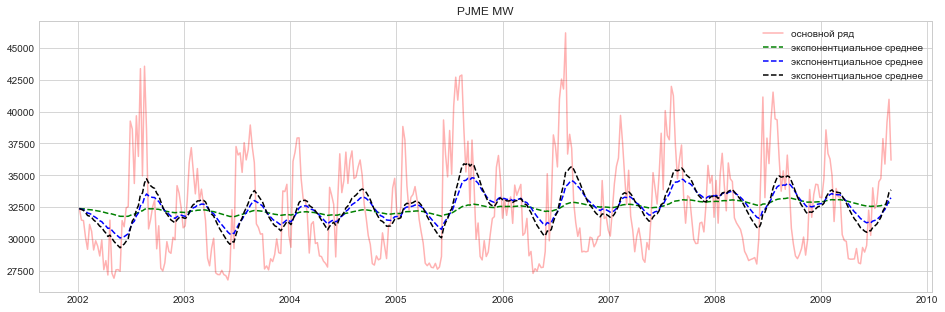

In [75]:
df_w['exp_0_01'] = exponential_smoothing(df_w['PJME_MW'], 0.01)
df_w['exp_0_03'] = exponential_smoothing(df_w['PJME_MW'], 0.03)
df_w['exp_0_04'] = exponential_smoothing(df_w['PJME_MW'], 0.04)
df_w['exp_0_06'] = exponential_smoothing(df_w['PJME_MW'], 0.06)
df_w['exp_0_07'] = exponential_smoothing(df_w['PJME_MW'], 0.07)
df_w['exp_0_08'] = exponential_smoothing(df_w['PJME_MW'], 0.08)

N100=400
plt.plot(df_w.index[:N100],df_w['PJME_MW'][:N100],'r',label ='основной ряд',alpha=0.3)
plt.plot(df_w.index[:N100],df_w['exp_0_01'][:N100],'--g',label ='экспонентциальное среднее')
plt.plot(df_w.index[:N100],df_w['exp_0_05'][:N100],'--b',label ='экспонентциальное среднее')
plt.plot(df_w.index[:N100],df_w['exp_0_08'][:N100],'--k',label ='экспонентциальное среднее')
plt.legend()
plt.title('PJME MW')
plt.show()

In [26]:
p = 12
for i in range(p):
    df_w['t'+str(p-i)]=0
    df_w['t'+str(p-i)].values[p:] = df_w['PJME_MW'].values[i:-(p)+i]

In [27]:
p = 12
for i in range(p):
    df_w['d'+str(p-i)]=0
    df_w['d'+str(p-i)].values[p:] = df_w['diff1'].values[i:-(p)+i]

Выделим существенные признаки

In [93]:
scl_target=StandardScaler() 
h=4
target = df_w['PJME_MW'].values[h+p:].reshape((df_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(850, 1)

In [94]:
scl_x=StandardScaler() 

X = df_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(850, 48)

Применим автоматизацию выбора через SelectKBest c выделением 15 лучших признаков.

In [95]:
sfk =SelectKBest(f_regression, k=15)
X_new =sfk.fit_transform(X, y.ravel())
X_new.shape

(850, 15)

In [96]:
column_names = df_w.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 'diff1_l', 'd_w4', 't12', 't11', 't10', 't9', 't8', 't7',
       't6', 't5', 't1', 'd3', 'd2', 'd1'],
      dtype='object')

In [97]:
# сделаем функцию разделения на тестовые и тренировочные
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

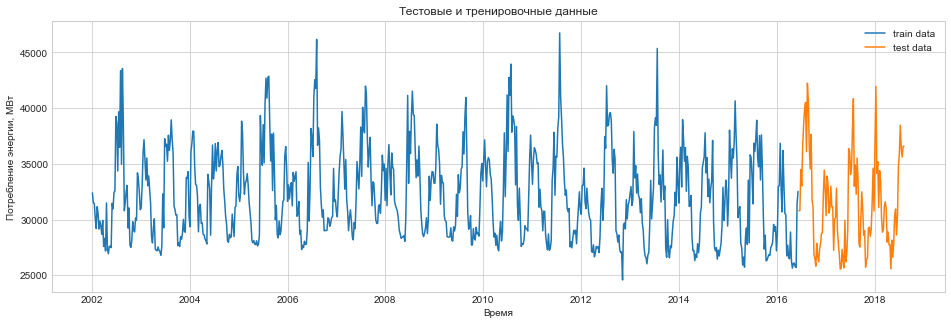

In [98]:
train, test = split_data(df_w, '06-06-2016')

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [99]:
X_train = X_new[:train.shape[0],:]
y_train = y[:train.shape[0],0]
X_test = X_new[train.shape[0]:,:]
y_test = y[train.shape[0]:,0]
train.shape

(753, 48)

Построим модель

In [100]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [101]:
param_dist = {"max_depth": [3, 2,10,14,5], 
              "n_estimators":[100,200,300,400,500, 1000]}

#  randomized search
n_iter_search = 10

In [37]:
%%time
model_gr = GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.475 (std: 0.138)
Parameters: {'n_estimators': 100, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.470 (std: 0.132)
Parameters: {'n_estimators': 200, 'max_depth': 2}

Model with rank: 3
Mean validation score: 0.470 (std: 0.118)
Parameters: {'n_estimators': 300, 'max_depth': 2}

Model with rank: 4
Mean validation score: 0.466 (std: 0.110)
Parameters: {'n_estimators': 200, 'max_depth': 5}

Model with rank: 5
Mean validation score: 0.425 (std: 0.127)
Parameters: {'n_estimators': 500, 'max_depth': 3}



In [108]:
model_g = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=100)

In [109]:
model_g.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

In [110]:
y_test_pred_g = model_g.predict(X_test)

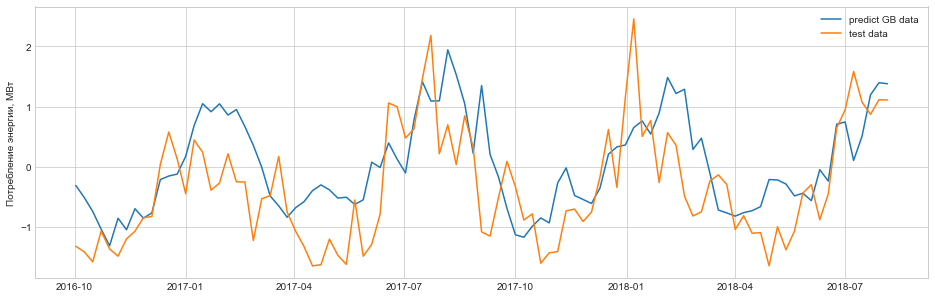

In [111]:
## plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

In [112]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [43]:
#Посмотрим на метрики качества
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test), 
                                      y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка mse :   0.6818289175036076 
ошибка mae  :   0.6642863434855245 
оценка R2 :   0.19850651140065634
ошибка градиентного бустинга MAPE :   8.85742000329341 %


Ошибки существенно выше, чем при ресемплинге по дням. И R2 очень низкий - если оценивать модель только по этой метрике, то она не удачная.

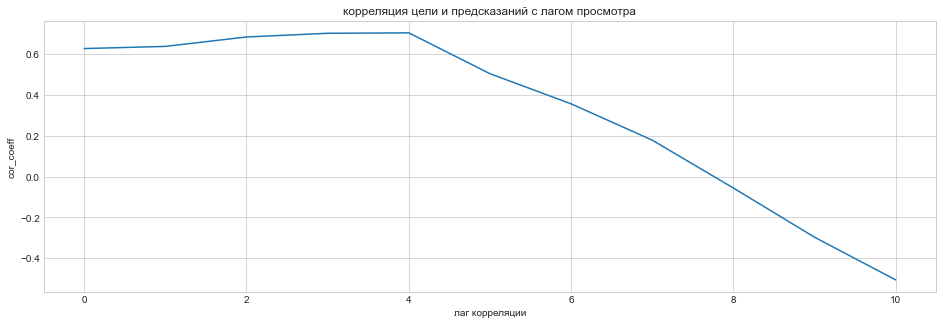

In [114]:
lag=10
p_cor=[np.corrcoef( y_test, y_test_pred_g)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

Выделим существенные признаки

In [182]:
scl_target=StandardScaler() 
h=1
target = df_w['PJME_MW'].values[h+p:].reshape((df_w.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(853, 1)

In [183]:
scl_x=StandardScaler() 

X = df_w.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(853, 48)

Применим автоматизацию выбора через SelectKBest c выделением лучших признаков.

In [211]:
sfk =SelectKBest(f_regression, k=13)
X_new =sfk.fit_transform(X, y.ravel())
X_new.shape

(853, 13)

In [212]:
column_names = df_w.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 'diff1_l', 'd_w4', 'exp_0_08', 't12', 't11', 't10', 't9',
       't8', 't4', 't3', 't2', 't1'],
      dtype='object')

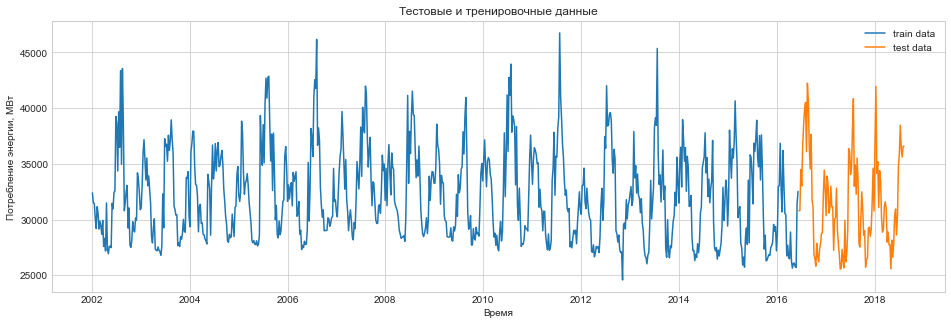

In [213]:
train, test = split_data(df_w, '06-06-2016')

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [214]:
X_train = X_new[:train.shape[0],:]
y_train = y[:train.shape[0],0]
X_test = X_new[train.shape[0]:,:]
y_test = y[train.shape[0]:,0]
train.shape

(753, 48)

Построим модель

In [215]:
param_dist = {"max_depth": [3,2,10,14,5], 
              "n_estimators":[100,200,300,400,500,1000]}

#  randomized search
n_iter_search = 10

In [216]:
%%time
model_gr = GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.661 (std: 0.047)
Parameters: {'n_estimators': 200, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.646 (std: 0.043)
Parameters: {'n_estimators': 200, 'max_depth': 5}

Model with rank: 3
Mean validation score: 0.642 (std: 0.044)
Parameters: {'n_estimators': 400, 'max_depth': 5}

Model with rank: 4
Mean validation score: 0.640 (std: 0.045)
Parameters: {'n_estimators': 500, 'max_depth': 5}

Model with rank: 5
Mean validation score: 0.633 (std: 0.045)
Parameters: {'n_estimators': 500, 'max_depth': 2}

Wall time: 1min 6s


In [217]:
model_g = GradientBoostingRegressor(max_depth=2, random_state=0, n_estimators=100)

In [218]:
model_g.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, random_state=0)

In [219]:
y_test_pred_g = model_g.predict(X_test)

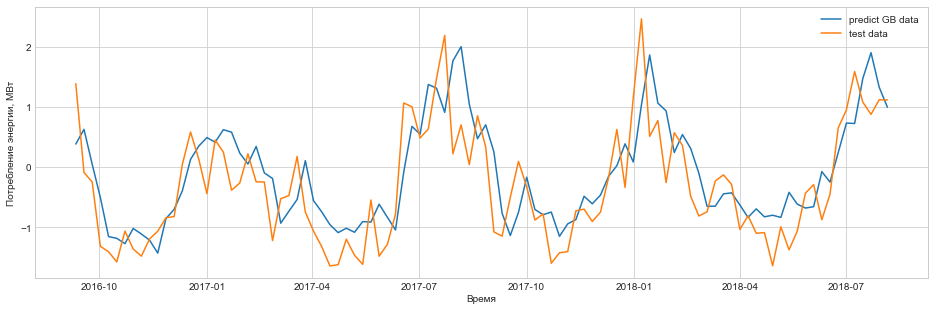

In [220]:
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

In [221]:
#Посмотрим на метрики качества
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test), 
                                      y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка mse :   0.39246678985280126 
ошибка mae  :   0.5084131587658041 
оценка R2 :   0.5413182307301048
ошибка градиентного бустинга MAPE :   6.586611601657536 %


R2 уже не выглядит таким страшным, но все еще очень низкий. Ошибки также уменьшились

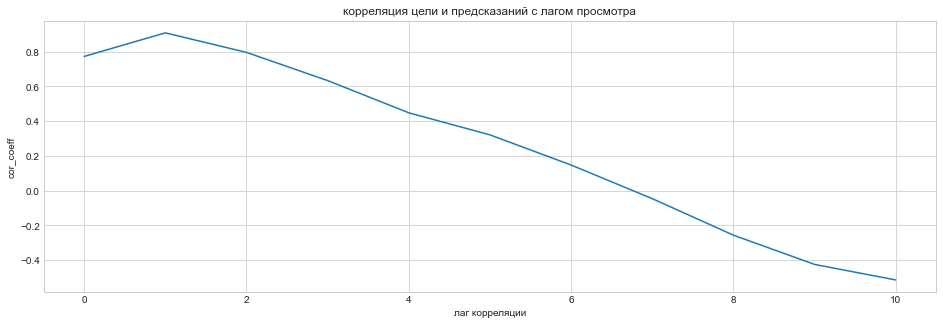

In [222]:
lag=10
p_cor=[np.corrcoef( y_test, y_test_pred_g)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

In [223]:
X_test_100[0]

array([ 0.61094342,  0.66458461,  1.80539815,  1.3291998 ,  1.48519563,
       -0.32291001, -0.31383208,  0.61253434,  0.24143403,  1.16105051,
        1.00842782,  2.54381543,  2.15939714,  1.10660111,  0.24706002])

In [281]:
X_test_100 = X_test.copy()
y_test_100 = y_test.copy()
N10 = 87

In [282]:
#Признаки, которые надо будет восстанавливать:
column_names

Index(['PJME_MW', 'diff1_l', 'd_w4', 'exp_0_08', 't12', 't11', 't10', 't9',
       't8', 't4', 't3', 't2', 't1'],
      dtype='object')

In [283]:
for i in range(p, N10+p):
    y_test_100[i] = model_g.predict(X_test_100[i,:].reshape((1,X_test_100.shape[1])))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1, 0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
    
    #строим 'diff1_l' - признак под номером 4
    # строим логарифм по значению ряда и скалируем признак по схеме 15-го признака из основного списка
    xy_i=(np.log((y_i))-scl_x.mean_[15])*scl_x.scale_[15]
    #устанавливаем новое значение для 4
    X_test_100[i+1, 1] = xy_i 
    
    #строим 'd_w4' - признак под номером 3
    X_test_100[i+1, 2] = np.mean(X_test_100[i-3:i+1,0]) 

    #строим 'exp_0_08'
    X_test_100[i+1, 3] = X_test_100[i,6]*(1-0.08)+ 0.08 * X_test_100[i+1,0]
    
    # обновим историю значенний
    X_test_100[i+1, 4] = X_test_100[i-12,0]
    X_test_100[i+1, 5] = X_test_100[i-11,0]
    X_test_100[i+1, 6] = X_test_100[i-10,0]
    X_test_100[i+1, 7] = X_test_100[i-9,0]
    X_test_100[i+1, 8] = X_test_100[i-8,0]
    X_test_100[i+1, 9] = X_test_100[i-4,0]
    X_test_100[i+1, 10] = X_test_100[i-3,0]
    X_test_100[i+1, 11] = X_test_100[i-2,0]
    X_test_100[i+1, 12] = X_test_100[i-1,0]

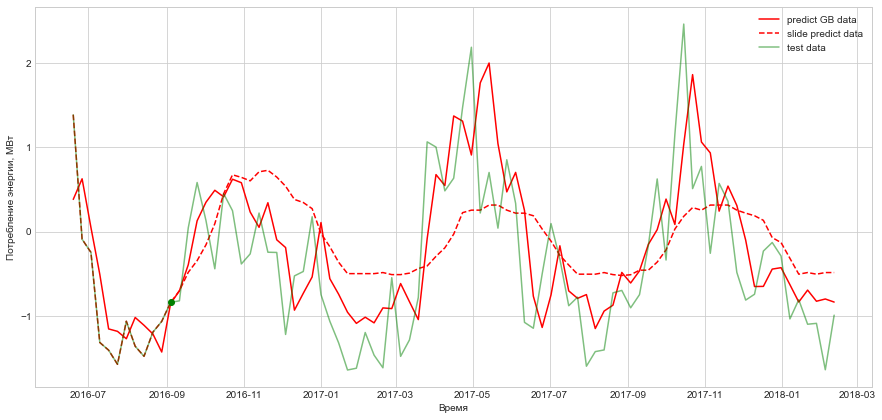

In [284]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[p],y_test[p-1], 'og', alpha=1)
plt.legend()
plt.show()    

In [295]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test[p:p+4]), 
                                          y_pred=scl_target.inverse_transform(y_test_100[p:p+4]))
print(f'ошибка градиентного бустинга MAPE на точках от 0 до 4:', er_g, '%')

ошибка градиентного бустинга MAPE на точках от 0 до 4: 5.622016957760557 %


Прогнозирование с помощью рекурсионной модели показало существенно ниже ошибку MAPE, чем прямое моделирование

5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

In [293]:
for i in range(10, 101, 10):
    er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test[p+i-10:p+i]), 
                                          y_pred=scl_target.inverse_transform(y_test_100[p+i-10:p+i]))
    print(f'ошибка градиентного бустинга MAPE на точках от {i-10} до {i}:', er_g, '%')

ошибка градиентного бустинга MAPE на точках от 0 до 10: 6.51887301965471 %
ошибка градиентного бустинга MAPE на точках от 10 до 20: 12.8630484731573 %
ошибка градиентного бустинга MAPE на точках от 20 до 30: 12.231667481899462 %
ошибка градиентного бустинга MAPE на точках от 30 до 40: 8.255602051674293 %
ошибка градиентного бустинга MAPE на точках от 40 до 50: 8.777903257216293 %
ошибка градиентного бустинга MAPE на точках от 50 до 60: 7.105999564138433 %
ошибка градиентного бустинга MAPE на точках от 60 до 70: 6.545831975397165 %
ошибка градиентного бустинга MAPE на точках от 70 до 80: 7.698140361297898 %
ошибка градиентного бустинга MAPE на точках от 80 до 90: 7.562331626478162 %
ошибка градиентного бустинга MAPE на точках от 90 до 100: nan %


6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

Ошибка MAPE ниже на первых 10 точках, конечно же. Далее она увеличивается, а потом снова уменьшается - график напомнинает скользящее среднее.